In [1]:
# Standard Library
import os
import sys
import json
import math
import random
from pathlib import Path
from typing import List, Optional, Tuple, Union
from collections import defaultdict

# Data Science & Utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DeepChem
import deepchem
from deepchem.molnet import *

# RDKit
from rdkit import Chem

# Torch
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast

# Accelerate
from accelerate import Accelerator

# Transformers
from transformers import (
    AutoModel, AutoModelForMaskedLM, AutoModelForSequenceClassification,
    AutoTokenizer, RobertaModel, RobertaTokenizer, RobertaTokenizerFast,
    RobertaConfig, RobertaPreTrainedModel, DebertaV2Model, DebertaV2Config,
    DebertaTokenizerFast, LongformerModel, LongformerConfig,
    LongformerForMaskedLM, LongformerTokenizerFast,
    AutoConfig, Trainer, TrainingArguments, pipeline,
    default_data_collator
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.trainer_pt_utils import get_parameter_names

# Tokenizers
from tokenizers import ByteLevelBPETokenizer
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing

# ESM
import esm

# Datasets
from datasets import Dataset, DatasetDict, load_from_disk

# Metrics
import sklearn
from sklearn.metrics import (
    root_mean_squared_error, mean_squared_error, roc_auc_score
)

# Bitsandbytes
import bitsandbytes as bnb

# Misc
import ipynbname


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\Kamen\anaconda3\envs\Work2\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


# Dataset Loading (if exists)

In [2]:
def get_notebook_name():
    try:
        return ipynbname.name()
    except Exception:
        return "unknown_notebook"

# Get the notebook's name
notebook_name = get_notebook_name().split(".")[0]  # Remove file extension if any
os.makedirs("result_graphs", exist_ok=True)

In [3]:
model_pth = "./GrandBookData/PubchemModelDeberta"
model_pth2 = "./GrandBookData/ProteinModelDeb"

In [4]:
# Define save paths
save_dir = "Data3"
inputdata_dir = os.path.join(save_dir, "inputdataAbsolute")

# Check if train and test datasets exist
train_datasets_path = os.path.join(inputdata_dir, "train_datasets")
test_datasets_path = os.path.join(inputdata_dir, "test_datasets")
tasks_path = os.path.join(inputdata_dir, "tasks.json")

# Check for the existence of datasets and tasks
if os.path.exists(train_datasets_path) and os.path.exists(test_datasets_path):
    # Load datasets if they exist
    train_datasets = load_from_disk(train_datasets_path)
    test_datasets = load_from_disk(test_datasets_path)
    with open(tasks_path, "r") as f:
        tasks = json.load(f)
    updated_datasets = {"train": train_datasets, "test": test_datasets}
    datasets_exist = True
    print("Datasets and tasks successfully loaded.")
else:
    datasets_exist = False
    print("Datasets not found. Skipping loading.")

Datasets and tasks successfully loaded.


In [5]:
# Unified task and dataset details
Datasets_Available = {
    "bace": {"load_fn": load_bace_classification,"problem_type": "multi_label_classification", "num_labels": 1},
    "hiv": {"load_fn": load_hiv,"problem_type": "multi_label_classification", "num_labels": 1},
    "bbbp": {"load_fn": load_bbbp,"problem_type": "multi_label_classification", "num_labels": 1},
    "clintox": {"load_fn": load_clintox,"problem_type": "multi_label_classification", "num_labels": 2},
    "tox21": {"load_fn": load_tox21,"problem_type": "multi_label_classification","num_labels": 12},
    "muv": {"load_fn": load_muv,"problem_type": "multi_label_classification", "num_labels": 17},
    "sider": {"load_fn": load_sider,"problem_type": "multi_label_classification", "num_labels": 27},
    "toxcast": {"load_fn": load_toxcast,"problem_type": "multi_label_classification", "num_labels": 617},
    "delaney": {"load_fn": load_delaney, "problem_type": "regression", "num_labels": 1},
    "freesolv": {"load_fn": load_freesolv, "problem_type": "regression", "num_labels": 1},
    "lipo": {"load_fn": load_lipo, "problem_type": "regression", "num_labels": 1},
}

num_labels_list = [value["num_labels"] for value in Datasets_Available.values()]
problem_type_list = [value["problem_type"] for value in Datasets_Available.values()]

tokenizer = DebertaTokenizerFast.from_pretrained(model_pth)
tokenizer2 = DebertaTokenizerFast.from_pretrained(model_pth2)
tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizerFast'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DebertaV2Tokenizer'. 
The class this function is called from is 'DebertaTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called fro

DebertaTokenizerFast(name_or_path='./GrandBookData/PubchemModelDeberta', vocab_size=2692, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[MASK]", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}

In [6]:
print(torch.cuda.memory_allocated())
print(torch.cuda.memory_reserved())

0
0


# Prepare dataset if not exists

In [7]:
def fix_weights(y,w):
    # Identify valid rows where the old weight is non-zero
    valid_mask = w != 0
    
    # Initialize new weights array
    new_w = np.zeros_like(w, dtype=float)

    dropped_labels_ids = []
    
    # Compute scaled weights for each label (column)
    for j in range(y.shape[1]):
        valid_entries = valid_mask[:, j]
        valid_y = y[valid_entries, j]
    
        # Count positives and negatives
        num_positives = np.sum(valid_y == 1)
        num_negatives = np.sum(valid_y == 0)

        if y.shape[1]>1 and (num_positives * num_negatives==0):
            print("Bad label", j)
            dropped_labels_ids.append(j)
        else:
            # Scale weights to ensure the smallest value is 1
            max_count = max(num_positives, num_negatives)
            weight_for_1 = max_count / (num_positives or 1)
            weight_for_0 = max_count / (num_negatives or 1)
            scale_factor = min(weight_for_1, weight_for_0)  # Scale to make the smallest weight 1
        
            # Assign weights
            new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)

    return new_w, dropped_labels_ids
def mask_string(s, n):
    """
    Masks n% of the characters in the string 's'.
    Alphabet characters (both uppercase and lowercase) are replaced with 'X',
    other chars (non-alphabetic) are replaced with '~'.
    """
    # List of the characters in the string for mutability
    masked_s = list(s)
    total_chars = len(s)
    
    # Calculate how many characters we need to mask (n% of the total characters)
    num_to_mask = max(1, int(total_chars * n / 100))  # Ensure at least one character is masked
    multiplier = (1-num_to_mask/total_chars)**3
    # Randomly select indices to mask
    indices_to_mask = random.sample(range(total_chars), num_to_mask)
    
    for idx in indices_to_mask:
        if s[idx].isalpha():  # If the character is an alphabetic letter
            masked_s[idx] = 'X'
        else:  # If it's not an alphabetic character
            masked_s[idx] = '~'

    return ''.join(masked_s), multiplier

def extend_dataset(strings, maxn, k, labels = [], weights=[]):
    """
    Extends the dataset by creating k masked versions for each string,
    plus the original string, with n% characters masked.
    """
    extended_dataset = []
    extended_dataset_labels = []
    extended_weights = []
    for i in range(len(strings)):
        s = strings[i]
        w = weights[i]
        extended_dataset.append(s)  # Add the original string
        extended_weights.append(w)
        if len(labels)==len(strings):
            extended_dataset_labels.append(labels[i])
        for _ in range(k-1):
            n = random.randint(5, maxn)
            new_string, multiplier = mask_string(s, n)
            #print(n, multiplier)
            extended_dataset.append(new_string)  # Add a masked version
            extended_weights.append(w*multiplier)  # Add a masked version
            if len(labels)==len(strings):
                extended_dataset_labels.append(labels[i])
    print("Extended from",len(strings),"to",len(extended_dataset))
    print("Example", extended_dataset[:3])
    print("Example", extended_weights[:3])
    return extended_dataset, extended_dataset_labels, extended_weights

def dataset_extractor(dataset, task_type,tasks, prototyping = False, extend_data = False):
    dataset_parts = []
    i = 0
    for data in dataset:
        molecules_text = [Chem.MolToSmiles(molecule, isomericSmiles=True, canonical = True) for molecule in data.X]
        target_labels = data.y.astype(float)
        
        new_w, dropped_labels_ids = fix_weights(target_labels, data.w )
        print(len(molecules_text))
        print(len(target_labels))
        print(len(new_w))
        if i ==0:
            if extend_data:
                max_train_size = 74470
                extending_coefficient = max_train_size//len(molecules_text)
                extending_percentage = 15
                if extending_coefficient>1:
                    molecules_text,target_labels,new_w = extend_dataset(molecules_text,extending_percentage,extending_coefficient,target_labels,new_w)
                    print(len(molecules_text))
                    print(len(target_labels))
                    print(len(new_w))
            if len(dropped_labels_ids)>0:
                dropped_tasks = tasks[dropped_labels_ids]
                print("____________________")
                print("____________________")
                print("Removed bad tasks with 1 class instead of 2 required after cleaning NaN")
                print(dropped_tasks)
                print("____________________")
                print("____________________")
                target_labels = np.delete(target_labels, dropped_labels_ids, axis=1)
                tasks = np.delete(tasks, dropped_labels_ids)

            i+=1
        if prototyping and len(molecules_text)>1000:
            part = int(len(molecules_text)/10)
            dataset_parts.append(Dataset.from_dict({"text": molecules_text[:part], "labels": target_labels[:part], "weights": new_w[:part]}) )
        else:
            dataset_parts.append(Dataset.from_dict({"text": molecules_text, "labels": target_labels, "weights": new_w}) )
        
    return dataset_parts, tasks

def tokenization(example):
    return tokenizer(example["text"],padding='max_length', truncation=True, max_length=512)

#target_datasets = ["clintox","bbbp", "lipo"]
target_datasets = list(Datasets_Available.keys())
prototyping = False
extend = False
stratifiedsplitter = deepchem.splits.RandomStratifiedSplitter()
simplesplitter = deepchem.splits.RandomSplitter()
#target_datasets = list(Datasets_Available.keys())
loaded_datasets = {}
for dataset_name in target_datasets:
    dataset_config = Datasets_Available[dataset_name]
    dataset_dc = dataset_config["load_fn"](featurizer="Raw",reload=False,split = None)
    #if "tasks_wanted" in dataset_config:
    tasks, dataset, transformers = dataset_dc
    #print(dataset)
    if dataset_config["problem_type"] == "regression":
        dataset = simplesplitter.train_test_split(dataset[0])
        #dataset = simplesplitter.train_valid_test_split(dataset[0])
    else:
        dataset = stratifiedsplitter.train_test_split(dataset[0])
        #dataset = stratifiedsplitter.train_valid_test_split(dataset[0])
    print(dataset_name)
    print(dataset)
    [train, test], tasks = dataset_extractor(dataset,dataset_config["problem_type"],tasks,prototyping,extend)
    #[train,valid, test], tasks = dataset_extractor(dataset,dataset_config["dataset_type"],tasks,prototyping)
    train = train.map(tokenization, batched=True)
    test = test.map(tokenization, batched=True)
    #valid = valid.map(tokenization, batched=True)
    loaded_dataset = {"train":train, "test":test, "tasks": tasks}
    #loaded_dataset = {"train":train, "test":test, "valid":valid, "tasks": tasks}
    loaded_datasets[dataset_name] = loaded_dataset
    

'split' is deprecated.  Use 'splitter' instead.


bace
(<DiskDataset X.shape: (np.int64(1210),), y.shape: (np.int64(1210), np.int64(1)), w.shape: (np.int64(1210), np.int64(1)), task_names: ['Class']>, <DiskDataset X.shape: (np.int64(303),), y.shape: (np.int64(303), np.int64(1)), w.shape: (np.int64(303), np.int64(1)), ids: ['S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(F)(F)F)Cc1ccccc1)C'
 'O1c2c(cc(cc2)CC)[C@@H]([NH2+]C[C@@H](O)[C@H]2NC(=O)C=3C=CC(=O)N(CCCCc4cc(C2)ccc4)C=3)CC12CCC2'
 'O=C1N(CCCC1)C(C)(C)[C@@H]1C[C@@H](CCC1)C(=O)N[C@H]([C@H](O)C[NH2+]Cc1cc(ccc1)C(C)C)Cc1ccccc1'
 ... 'Clc1cc2CC(N=C(NC(Cc3ccccc3)c3oc(nn3)C)c2cc1)(C)C'
 'Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N'
 'Clc1cc2nc(n(c2cc1)CCCC(=O)NCC1CC1)N'], task_names: ['Class']>)
1210
1210
1210
303
303
303


Map:   0%|          | 0/1210 [00:00<?, ? examples/s]

Map:   0%|          | 0/303 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[13:55:19] WARNING: not removing hydrogen atom without neighbors
[13:55:19] WARNING: not removing hydrogen atom without neighbors


hiv
(<DiskDataset X.shape: (np.int64(32902),), y.shape: (np.int64(32902), np.int64(1)), w.shape: (np.int64(32902), np.int64(1)), task_names: ['HIV_active']>, <DiskDataset X.shape: (np.int64(8225),), y.shape: (np.int64(8225), np.int64(1)), w.shape: (np.int64(8225), np.int64(1)), task_names: ['HIV_active']>)
32902
32902
32902
8225
8225
8225


Map:   0%|          | 0/32902 [00:00<?, ? examples/s]

Map:   0%|          | 0/8225 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[13:55:59] Explicit valence for atom # 1 N, 4, is greater than permitted
Failed to featurize datapoint 59, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[13:55:59] WARNING: not removing hydrogen atom without neighbors
[13:55:59] Explicit valence for atom # 6 N, 4, is greater than permitted
Failed to featurize datapoint 61, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=

bbbp
(<DiskDataset X.shape: (np.int64(1631),), y.shape: (np.int64(1631), np.int64(1)), w.shape: (np.int64(1631), np.int64(1)), task_names: ['p_np']>, <DiskDataset X.shape: (np.int64(408),), y.shape: (np.int64(408), np.int64(1)), w.shape: (np.int64(408), np.int64(1)), ids: ['c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO3)=O'
 'Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)[C@@H](N4C3=O)C(O)=O'
 'NC(N)=NC(=O)c1nc(Cl)c(N)nc1N' ...
 'C1=C(C(F)(F)F)C=CC3=C1N(C2=CC=CC=C2)C(CC(N3C)=O)=O'
 'C(C(C(CC)C)C(N)=O)C' 'C1=C(Cl)C(=C(C2=C1NC(=O)C(N2)=O)[N+](=O)[O-])Cl'], task_names: ['p_np']>)
1631
1631
1631
408
408
408


Map:   0%|          | 0/1631 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[13:56:03] Explicit valence for atom # 0 N, 5, is greater than permitted
Failed to featurize datapoint 7, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[13:56:04] Can't kekulize mol.  Unkekulized atoms: 9
Failed to featurize datapoint 302, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[13:56:04] Can't kekulize mol.  Unkekulized atoms: 4
Failed to featurize datap

clintox
(<DiskDataset X.shape: (np.int64(1185),), y.shape: (np.int64(1185), np.int64(2)), w.shape: (np.int64(1185), np.int64(2)), task_names: ['FDA_APPROVED' 'CT_TOX']>, <DiskDataset X.shape: (np.int64(295),), y.shape: (np.int64(295), np.int64(2)), w.shape: (np.int64(295), np.int64(2)), ids: ['*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC'
 '[H]/[NH+]=C(\\N)/c1ccc(cc1)OCCCCCOc2ccc(cc2)/C(=[NH+]/[H])/N'
 '[N+](=O)([O-])[O-]' ... 'O1[As]2O[As]1O2' 'OCl(=O)(=O)=O' 'S=[Se]=S'], task_names: ['FDA_APPROVED' 'CT_TOX']>)
1185
1185
1185
295
295
295


Map:   0%|          | 0/1185 [00:00<?, ? examples/s]

Map:   0%|          | 0/295 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[13:56:06] WARNING: not removing hydrogen atom without neighbors


tox21
(<DiskDataset X.shape: (np.int64(6265),), y.shape: (np.int64(6265), np.int64(12)), w.shape: (np.int64(6265), np.int64(12)), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>, <DiskDataset X.shape: (np.int64(1566),), y.shape: (np.int64(1566), np.int64(12)), w.shape: (np.int64(1566), np.int64(12)), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>)
6265
6265
6265
1566
1566
1566


Map:   0%|          | 0/6265 [00:00<?, ? examples/s]

Map:   0%|          | 0/1566 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


muv
(<DiskDataset X.shape: (np.int64(74470),), y.shape: (np.int64(74470), np.int64(17)), w.shape: (np.int64(74470), np.int64(17)), task_names: ['MUV-466' 'MUV-548' 'MUV-600' ... 'MUV-852' 'MUV-858' 'MUV-859']>, <DiskDataset X.shape: (np.int64(18617),), y.shape: (np.int64(18617), np.int64(17)), w.shape: (np.int64(18617), np.int64(17)), task_names: ['MUV-466' 'MUV-548' 'MUV-600' ... 'MUV-852' 'MUV-858' 'MUV-859']>)
74470
74470
74470
18617
18617
18617


Map:   0%|          | 0/74470 [00:00<?, ? examples/s]

Map:   0%|          | 0/18617 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors
[13:58:29] WARNING: not removing hydrogen atom without neighbors


sider
(<DiskDataset X.shape: (np.int64(1146),), y.shape: (np.int64(1146), np.int64(27)), w.shape: (np.int64(1146), np.int64(27)), task_names: ['Hepatobiliary disorders' 'Metabolism and nutrition disorders'
 'Product issues' ... 'Cardiac disorders' 'Nervous system disorders'
 'Injury, poisoning and procedural complications']>, <DiskDataset X.shape: (np.int64(281),), y.shape: (np.int64(281), np.int64(27)), w.shape: (np.int64(281), np.int64(27)), ids: ['CC(C)(C)C1=CC(=C(C=C1NC(=O)C2=CNC3=CC=CC=C3C2=O)O)C(C)(C)C'
 'CC[C@]12CC(=C)[C@H]3[C@H]([C@@H]1CC[C@]2(C#C)O)CCC4=CCCC[C@H]34'
 'CCCCCCOC(=O)N=C(C1=CC=C(C=C1)NCC2=NC3=C(N2C)C=CC(=C3)C(=O)N(CCC(=O)OCC)C4=CC=CC=N4)N'
 ...
 'CCCC1=NC(=C(N1CC2=CC=C(C=C2)C3=CC=CC=C3C4=NNN=N4)C(=O)OCC5=C(OC(=O)O5)C)C(C)(C)O'
 'C[C@H]1CN(CC[C@@]1(C)C2=CC(=CC=C2)O)C[C@H](CC3=CC=CC=C3)C(=O)NCC(=O)O.O.O'
 'CC[C@@H]1[C@@]2([C@@H]([C@@H](C(=O)[C@@H](C[C@@]([C@@H]([C@H](C(=O)[C@H](C(=O)O1)C)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)OC)C)C)N(C(=O)O2)CCCCN4C=C(N=C4)C5

Map:   0%|          | 0/1146 [00:00<?, ? examples/s]

Map:   0%|          | 0/281 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.
[13:58:34] Explicit valence for atom # 0 F, 2, is greater than permitted
Failed to featurize datapoint 1039, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[13:58:35] Explicit valence for atom # 2 Cl, 2, is greater than permitted
Failed to featurize datapoint 1789, None. Appending empty array
Exception message: Python argument types in
    rdkit.Chem.rdmolfiles.CanonicalRankAtoms(NoneType)
did not match C++ signature:
    CanonicalRankAtoms(class RDKit::ROMol mol, bool breakTies=True, bool includeChirality=True, bool includeIsotopes=True, bool includeAtomMaps=True, bool includeChiralPresence=False)
[13:58:35] Explicit valence for atom # 0 Cl, 2, is gr

toxcast
(<DiskDataset X.shape: (np.int64(6862),), y.shape: (np.int64(6862), np.int64(617)), w.shape: (np.int64(6862), np.int64(617)), task_names: ['ACEA_T47D_80hr_Negative' 'ACEA_T47D_80hr_Positive'
 'APR_HepG2_CellCycleArrest_24h_dn' ... 'Tanguay_ZF_120hpf_TRUN_up'
 'Tanguay_ZF_120hpf_TR_up' 'Tanguay_ZF_120hpf_YSE_up']>, <DiskDataset X.shape: (np.int64(1715),), y.shape: (np.int64(1715), np.int64(617)), w.shape: (np.int64(1715), np.int64(617)), task_names: ['ACEA_T47D_80hr_Negative' 'ACEA_T47D_80hr_Positive'
 'APR_HepG2_CellCycleArrest_24h_dn' ... 'Tanguay_ZF_120hpf_TRUN_up'
 'Tanguay_ZF_120hpf_TR_up' 'Tanguay_ZF_120hpf_YSE_up']>)
6862
6862
6862
1715
1715
1715


Map:   0%|          | 0/6862 [00:00<?, ? examples/s]

Map:   0%|          | 0/1715 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


delaney
(<DiskDataset X.shape: (np.int64(902),), y.shape: (np.int64(902), np.int64(1)), w.shape: (np.int64(902), np.int64(1)), ids: ['COC(=O)C1=C(C)NC(=C(C1c2ccccc2N(=O)=O)C(=O)OC)C ' 'CC(C)(C)CCO'
 'CSCS(=O)CC(CO)NC(=O)C=Cc1c(C)[nH]c(=O)[nH]c1=O' ...
 'c1cc2ccc(OC)c(CC=C(C)(C))c2oc1=O ' 'CCN(CC)C(=S)SCC(Cl)=C' 'CCCCCCO'], task_names: ['measured log solubility in mols per litre']>, <DiskDataset X.shape: (np.int64(226),), y.shape: (np.int64(226), np.int64(1)), w.shape: (np.int64(226), np.int64(1)), ids: ['Cc1cc2c3ccccc3ccc2c4ccccc14' 'ClC(Cl)(Cl)Cl' 'CC1CO1' ...
 'CCC(Br)(CC)C(=O)NC(N)=O' 'CC(=C)C1CC=C(C)C(=O)C1' 'CCCN(=O)=O'], task_names: ['measured log solubility in mols per litre']>)
902
902
902
226
226
226


C:\Users\Kamen\AppData\Local\Temp\ipykernel_14540\2654634398.py:30: RuntimeWarning: invalid value encountered in scalar divide
  new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)


Map:   0%|          | 0/902 [00:00<?, ? examples/s]

Map:   0%|          | 0/226 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


freesolv
(<DiskDataset X.shape: (np.int64(513),), y.shape: (np.int64(513), np.int64(1)), w.shape: (np.int64(513), np.int64(1)), ids: ['CC' 'Cc1ccc(nc1)C' 'c1cc(c(cc1O)Cl)Cl' ... 'CCCCCCc1ccccc1' 'CCCC(=O)C'
 'Cc1cccc(c1)[N+](=O)[O-]'], task_names: ['y']>, <DiskDataset X.shape: (np.int64(129),), y.shape: (np.int64(129), np.int64(1)), w.shape: (np.int64(129), np.int64(1)), ids: ['c1cc2c(cc1Cl)Oc3ccc(cc3O2)Cl' 'CCCCOCCCC' 'CCc1ccc(cc1)O' ...
 'CCCc1ccc(c(c1)OC)O' 'COP(=S)(OC)Oc1ccc(cc1)[N+](=O)[O-]'
 'c1ccc(cc1)c2cc(ccc2Cl)Cl'], task_names: ['y']>)
513
513
513
129
129
129


C:\Users\Kamen\AppData\Local\Temp\ipykernel_14540\2654634398.py:30: RuntimeWarning: invalid value encountered in scalar divide
  new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)


Map:   0%|          | 0/513 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

'split' is deprecated.  Use 'splitter' instead.


lipo
(<DiskDataset X.shape: (np.int64(3360),), y.shape: (np.int64(3360), np.int64(1)), w.shape: (np.int64(3360), np.int64(1)), task_names: ['exp']>, <DiskDataset X.shape: (np.int64(840),), y.shape: (np.int64(840), np.int64(1)), w.shape: (np.int64(840), np.int64(1)), ids: ['CCS(=O)(=O)Nc1cccc2c1c(Oc3ccc(Cl)cc3)c(C)n2CC(=O)O'
 'CCCSc1nc(N[C@@H]2C[C@H]2c3ccccc3)c4nnn([C@@H]5C[C@H](OCCO)[C@@H](O)[C@H]5O)c4n1'
 'Cc1c(CCC(=O)O)c[nH]c1\\C=C\\2/C(=O)Nc3ccccc23' ...
 'CN(C)c1nc(nc(n1)N(C)C)N(C)C'
 'O=C(CC1CCCCCC1)Nc2cccc3C(=O)N(C=Cc23)[C@H]4CCNC4'
 'Cn1cc(nc1c2c3C(=O)N(CC#C)C(=O)N(CC4CC4)c3nn2Cc5ccnc6ccc(Cl)cc56)C#N'], task_names: ['exp']>)


C:\Users\Kamen\AppData\Local\Temp\ipykernel_14540\2654634398.py:30: RuntimeWarning: invalid value encountered in scalar divide
  new_w[valid_entries, j] = np.where(valid_y == 1, weight_for_1 / scale_factor, weight_for_0 / scale_factor)


3360
3360
3360
840
840
840


Map:   0%|          | 0/3360 [00:00<?, ? examples/s]

Map:   0%|          | 0/840 [00:00<?, ? examples/s]

In [8]:
def analyze_clipped_samples(dataset_dict, tokenizer):
    clipped_stats = {}

    for dataset_name, dataset in dataset_dict.items():
        train_set = dataset.get("train")
        test_set = dataset.get("test")

        for split_name, split in [("train", train_set), ("test", test_set)]:
            if split is None:
                continue

            clipped_lengths = []
            for example in split:
                # Check if truncation is likely
                if example["attention_mask"][-2] == 1:
                    original_text = example["text"]
                    decoded_text = tokenizer.decode(example["input_ids"], skip_special_tokens=True)

                    # If the decoded text is shorter, truncation happened
                    if len(decoded_text) < len(original_text):
                        clipped_length = len(original_text) - len(decoded_text)
                        clipped_lengths.append(clipped_length)
                        #print(original_text)
                        #print(decoded_text)
                        #print(original_text[-clipped_length:])
            # Store stats
            if clipped_lengths:
                avg_clipped = sum(clipped_lengths) / len(clipped_lengths)
            else:
                avg_clipped = 0

            clipped_stats[f"{dataset_name}_{split_name}"] = {
                "total_clipped": len(clipped_lengths),
                "avg_clipped_length": avg_clipped
            }

    return clipped_stats

# Example usage
#clipped_data = analyze_clipped_samples(loaded_datasets, tokenizer)
#for eh in clipped_data:
    #print(eh, clipped_data[eh])

In [9]:
updated_datasets = {}
for dataset_name in loaded_datasets:
    for dataset_type in loaded_datasets[dataset_name]:
        #print(loaded_datasets)
        if dataset_type not in updated_datasets:
            updated_datasets[dataset_type] = {}
        if dataset_name not in updated_datasets[dataset_type] and dataset_type in ["train","test","valid"]:
            updated_datasets[dataset_type][dataset_name] = loaded_datasets[dataset_name][dataset_type].remove_columns(["text"])
            updated_datasets[dataset_type][dataset_name].set_format("torch")
            #print(dataset_type, dataset_name)
        elif dataset_name not in updated_datasets[dataset_type]:
            updated_datasets[dataset_type][dataset_name] = loaded_datasets[dataset_name][dataset_type]
for entry in updated_datasets["train"]["clintox"]['labels']:
    if entry[0] == entry[1]:
        print(entry)
print(updated_datasets.keys())
for key in updated_datasets.keys():
    print(updated_datasets[key].keys())

tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
tensor([1., 1.])
dict_keys(['train', 'test', 'tasks'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo'])


In [10]:
# Loop through all Excel files in the directory and process them
file_names = [] 
folder_path = 'GrandBookData/'

# Get list of all files in the directory
file_list = os.listdir(folder_path)

# Filter out 'train' files that specifically contain 'davis_train' or 'kiba_train'
train_files = [os.path.join(folder_path, file) for file in file_list if 'train' in file and ('davis' in file or 'kiba' in file)]

# Filter out 'test' files that specifically contain 'davis_test' or 'kiba_test'
test_files = [os.path.join(folder_path, file) for file in file_list if 'test' in file and ('davis' in file or 'kiba' in file)]

print("Training Files:")
print(train_files)

print("\nTest Files:")
print(test_files)

Training Files:
['GrandBookData/davis_train.csv', 'GrandBookData/kiba_train.csv']

Test Files:
['GrandBookData/davis_test.csv', 'GrandBookData/kiba_test.csv']


In [11]:
def tokenization2(example):
    # Tokenize compound_iso_smiles using tokenizer1
    smiles_encodings = tokenizer(
        example["compound_iso_smiles"], padding="max_length", truncation=True, max_length=512
    )
    # Tokenize target_sequence using tokenizer2
    sequence_encodings = tokenizer2(
        example["target_sequence"], padding="max_length", truncation=True, max_length=512
    )
    # Add tokenized outputs to the example
    example["input_ids"] = smiles_encodings["input_ids"]
    example["attention_mask"] = smiles_encodings["attention_mask"]
    example["input_ids2"] = sequence_encodings["input_ids"]
    example["attention_mask2"] = sequence_encodings["attention_mask"]
    return example
    
def analyze_clipped_samples2(dataset_name,train_set, tokenizer, encoder_type,text_target):
    clipped_stats = {}

    for split_name, split in [(dataset_name, train_set)]:
        if split is None:
            continue

        clipped_lengths = []
        for example in split:
            # Check if truncation is likely
            if example["attention_mask"+encoder_type][-1] == 1:
                original_text = example[text_target]
                if encoder_type == "3":
                    decoded_text = tokenizer.decode(example["input_ids2"], skip_special_tokens=True) + tokenizer.decode(example["input_ids"+encoder_type], skip_special_tokens=True)
                else:
                    decoded_text = tokenizer.decode(example["input_ids"+encoder_type], skip_special_tokens=True)
                # If the decoded text is shorter, truncation happened
                if len(decoded_text) < len(original_text):
                    clipped_length = len(original_text) - len(decoded_text)
                    clipped_lengths.append(clipped_length)

        # Store stats
        if clipped_lengths:
            avg_clipped = sum(clipped_lengths) / len(clipped_lengths)
        else:
            avg_clipped = 0

        clipped_stats[f"{dataset_name}_{split_name}"] = {
            "text_target" : text_target,
            "total_clipped": len(clipped_lengths),
            "avg_clipped_length": avg_clipped
        }

    return clipped_stats
    
def tokenization3(example):
    batch_size = len(example["compound_iso_smiles"])  # Get batch size

    # Tokenize compound_iso_smiles
    smiles_encodings = tokenizer(
        example["compound_iso_smiles"], padding="max_length", truncation=True, max_length=512
    )

    # Tokenize target_sequence
    tokenized_full = tokenizer2(example["target_sequence"], return_offsets_mapping=True)

    input_ids_full_batch = tokenized_full["input_ids"]

    # Ensure input_ids_full_batch is a list of lists (flatten if necessary)
    if isinstance(input_ids_full_batch[0], list):
        input_ids_full_batch = [tokens if isinstance(tokens, list) else [tokens] for tokens in input_ids_full_batch]

    input_ids2_batch, input_ids3_batch = [], []
    attention_mask2_batch, attention_mask3_batch = [], []

    for input_ids_full in input_ids_full_batch:
        input_ids_1 = input_ids_full[:512]  # First 512 tokens
        input_ids_2 = input_ids_full[512:]  # Remaining tokens

        input1_len = len(input_ids_1)
        input2_len = min(len(input_ids_2), 512)  # Ensure max length 512

        # Pad to ensure uniform length
        input_ids_1 = input_ids_1 + [tokenizer.pad_token_id] * (512 - input1_len)
        input_ids_2 = input_ids_2[:input2_len] + [tokenizer.pad_token_id] * (512 - input2_len)

        # Attention masks
        attention_mask2 = [1] * input1_len + [0] * (512 - input1_len)
        attention_mask3 = [1] * input2_len + [0] * (512 - input2_len)

        # Append to batch lists
        input_ids2_batch.append(input_ids_1)
        input_ids3_batch.append(input_ids_2)
        attention_mask2_batch.append(attention_mask2)
        attention_mask3_batch.append(attention_mask3)

    return {
        "input_ids": smiles_encodings["input_ids"],
        "attention_mask": smiles_encodings["attention_mask"],
        "input_ids2": input_ids2_batch,
        "input_ids3": input_ids3_batch,
        "attention_mask2": attention_mask2_batch,
        "attention_mask3": attention_mask3_batch,
    }
    
def tokens_to_string(tokens, alphabet):
    """
    Convert ESM token IDs back to amino acid sequence string (without special tokens).
    """
    # Convert token IDs to token strings
    token_strs = [alphabet.get_tok(tok) for tok in tokens if tok != alphabet.padding_idx]

    # Remove special tokens if present (e.g., <cls>, <eos>)
    special_tokens = {"<cls>", "<pad>", "<eos>"}
    token_strs = [tok for tok in token_strs if tok not in special_tokens]

    # Join the tokens to form the sequence
    return "".join(token_strs)

def canonicalize_smiles(example):
    sequence = example["compound_iso_smiles"]
    molecule = Chem.MolFromSmiles(sequence, sanitize=True)
    if molecule is not None:
        example["compound_iso_smiles"] = Chem.MolToSmiles(molecule, isomericSmiles=True, canonical=True)
        return example  # Keep valid entries
    else:
        return None  # Remove invalid rows


def append_to_datasets(file_paths, split_name, updated_datasets, task_name="affinity"):
    for file_path in file_paths:
        file_name = os.path.basename(file_path).split("_")[0]  
        # Extract the task name (e.g., "davis" or "kiba")
        # Load CSV into a Pandas DataFrame
        df = pd.read_csv(file_path)
        # Convert to Hugging Face Dataset
        dataset = Dataset.from_pandas(df)
        # Tokenize using `.map`
        dataset = dataset.map(canonicalize_smiles).filter(lambda x: x is not None)
        tokenized_dataset = dataset.map(tokenization3, batched=True)
        # Rename the 'affinity' column to 'labels'
        tokenized_dataset = tokenized_dataset.rename_column("affinity", "labels")
        # Add a 'weights' column with default values (None)
        #tokenized_dataset = tokenized_dataset.add_column("weights", [None] * len(tokenized_dataset))
        clipped_data = analyze_clipped_samples2(file_path,tokenized_dataset, tokenizer,"","compound_iso_smiles")
        print(clipped_data)
        clipped_data2 = analyze_clipped_samples2(file_path,tokenized_dataset, tokenizer2,"3","target_sequence")
        print(clipped_data2)
        # Select relevant columns
        tokenized_dataset = tokenized_dataset.remove_columns(
            ["compound_iso_smiles", "target_sequence"]  # Original text columns
        )
        # Append to the train/test dataset
        updated_datasets[split_name][file_name] = tokenized_dataset
        updated_datasets[split_name][file_name].set_format("torch")
        if file_name not in updated_datasets["tasks"]:
            updated_datasets["tasks"][file_name] = []
            updated_datasets["tasks"][file_name].append(task_name)

# Create updated_datasets dictionary
# Append train files
append_to_datasets(train_files, "train", updated_datasets)

# Append test files
append_to_datasets(test_files, "test", updated_datasets)

# Example Access:
print(updated_datasets["train"]["davis"])
print(updated_datasets["tasks"]["davis"])

Map:   0%|          | 0/25046 [00:00<?, ? examples/s]

Filter:   0%|          | 0/25046 [00:00<?, ? examples/s]

Map:   0%|          | 0/25046 [00:00<?, ? examples/s]

{'GrandBookData/davis_train.csv_GrandBookData/davis_train.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/davis_train.csv_GrandBookData/davis_train.csv': {'text_target': 'target_sequence', 'total_clipped': 165, 'avg_clipped_length': 61.27272727272727}}


Map:   0%|          | 0/98545 [00:00<?, ? examples/s]

Filter:   0%|          | 0/98545 [00:00<?, ? examples/s]

Map:   0%|          | 0/98545 [00:00<?, ? examples/s]

{'GrandBookData/kiba_train.csv_GrandBookData/kiba_train.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/kiba_train.csv_GrandBookData/kiba_train.csv': {'text_target': 'target_sequence', 'total_clipped': 549, 'avg_clipped_length': 484.30054644808746}}


Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5010 [00:00<?, ? examples/s]

Map:   0%|          | 0/5010 [00:00<?, ? examples/s]

{'GrandBookData/davis_test.csv_GrandBookData/davis_test.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/davis_test.csv_GrandBookData/davis_test.csv': {'text_target': 'target_sequence', 'total_clipped': 39, 'avg_clipped_length': 61.58974358974359}}


Map:   0%|          | 0/19709 [00:00<?, ? examples/s]

Filter:   0%|          | 0/19709 [00:00<?, ? examples/s]

Map:   0%|          | 0/19709 [00:00<?, ? examples/s]

{'GrandBookData/kiba_test.csv_GrandBookData/kiba_test.csv': {'text_target': 'compound_iso_smiles', 'total_clipped': 0, 'avg_clipped_length': 0}}
{'GrandBookData/kiba_test.csv_GrandBookData/kiba_test.csv': {'text_target': 'target_sequence', 'total_clipped': 115, 'avg_clipped_length': 456.9478260869565}}
Dataset({
    features: ['labels', 'input_ids', 'attention_mask', 'input_ids2', 'input_ids3', 'attention_mask2', 'attention_mask3'],
    num_rows: 25046
})
['affinity']


In [12]:
updated_datasets['train']['davis'][0]['input_ids2'].shape

torch.Size([512])

In [13]:
a = {"compound_iso_smiles":["Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)C(=O)NC2=O)c2ccccc21"],"target_sequence":["MAAKMIALGLLLLLAVASSQAQFNCTFESGFCGWTQPVNAPLNWTLNNGSTASFGTGPSQDHTTGSGLYIYIEASFVQSNILATLLSPLVTSGQACLTFWYHMYGPDVATLNVSTTVNNQDSLLWQRSGTQGNKWQLARIQFSPNTNYQIKFVAKRGSGFAGDIALDDISMIPKACPLTTNCDFEIGTCKWVQDQTDGFDWIRGRNGNDQNGQGPPMDHTLQSPVGYYLYTSSSSNPDKTARVMISPPFPPTPPIGKCMNFYYRLTANAGTLRVFNQINGARGTPLWQESGNQQGLWKPGQVTMNSTSGTWQPVFQAETANGQGTIAIDDVSFFDQACPPPGNCNFENGYCTWMNAIAGDNFDWIRHQGSVPSTLTGPLSDHTLGTANGYYIYMEATGRQRGQKTVLQSMVFPPAPNGRCLSFWYHMYSPFAFGQASSLSIYIQKVGSNFGSILWLRNSSAGDVWHNAHVAFSSSQSYQILIVATRGQSSLSDVAIDDISFTTTCNASFTRPTPKPTQASTALPSTSYDCTFENGFCTWTQDLTDSLNWTRHQGPTSSSDTGPRVDHTTSSTSGWYAYVEGSHFFSNNTARLISATITPTTGPMCFRFWYYMFGEDIDTFNVYFKFGNVLGSKVWTRKGNQGPSWKLAQLQFQQSIPFQLVLETTHISGNYRSDIAVDDIKFNFQQCPPRSLCDFEDSSRCGYTQDINDNFDWTYFTGAGVAGQWSPINDHTTYTSSGHSFFANMKSQSTGAVARLNSNEQPPTAGSCLSFWYIAYGSNYGSLSVYTQIGGTLNKIWSVPTTGITEAARAWLGMQVTVQSQQPYFITFEAARATGINGTVAIDDVNISPGVCPPLGDCSFEKGTCLWRNAVSLDKLDLLRWSGPTPTAGTGPSSDHTLGTDAGHFMYLESSLASKGDNAIFFSPEFGPRSTPRCFTFWYHMYARNKDQMGSLLVVFSDINSNSVIKNITGYQGPKWNYAAVPLQSSTLPHWVAFDLIRGSGSYSDIAIDDVIFYDGACPTEPATPSPNPCAVRCYSDFSKCIPSNQVCDYNMNCPDGRDELNCGGCSFESNTCQYTINAGSDTWVRGKYDTPKGNIMPQVDHTTKSTTGWYMLVTDATGLNFGDAKLTSKKLPPTSATCQVRFWYFSYGNSTRTSDLDVSFIEGPIPKTRMIKIRNVNSNKWQQGIAYMGRRVQPYQLTFEGSRDFLGRSYMAIDDISMYECGMPPKLPSCSSNQFHCGQTKACVDSNLICDFQDDCGDGTDEAQCAAFNGCNFENGICDWSQVSGSDDFNWDRTSGTTFTSYTGPSRDHTTGTVTGYYLYIDGFFESAGAKAQLKSKWFQPNTSGKCKIRLWYHMRGTGIGALNVYAVPNGGKLIKIWSRSGQLGDVWLRMEAPVVSSRYFYFMIEAVRGSSDESDIAIDDISFTTDCKYASGTVPSVPTGTLPTIVPSQVPSCSSWSTPNCGSCNFDQGQCGWRDTSIGGISGWIRDSAGNGQSFNGPLYDHTSNSGLGYYMYTKAKGGSFLTDSKLTSPMMPAAYDTCTISFWYNKTISSTLGLYVVQNGTSTRLWRSSFSFITNPNEPLWANASAGIGHRSQGYKLEFRISGSSFSTSNGVAAIDDISFTGCNMPPSVPCFSGNFQCKNGRCVSPSVVCDFANDCGDSSDEIGCAAALPWSCNFEKDDCGLIQDQTDTFNWRRDFGGTFSSLSGPNFDHTLASSKGYYMFFSARSSSLNKTARQTIPQTFGTPGTGCQMRFWYHMFGPDIGGLNIYARTNFMGPLIKQYSIIGNQGDIWKKASLTFSVNAPFQVVIEAVNGKYLWGDIAIDDISFTSGCTKVNTPLPYAQQTDPGCPTGQRRCGTTGPCKPSSVFCDFRNDCGDNSDEASCPSSCTFENGMCGWKSPKELGDIQWRRNRGGTPTQFTGPTTDHTNGNGWYMYVEADNGTFSDNAYLISPFYQNPGLSCTLSFWYHMYGFDIGSLKVQIASPTGTKQLWSKSNGQGNKWIQATNIPIPRCASAFQISFIGSTDFFGTAGDIAVDDISLNNCLKTTQTTCASGQLKCADNSACYPVSSKCDFGQDCCDSSDENSCTGYTRCNFENGLCGWMQLKSDNFDWEAEQGSTISSGTGPQADHTTGTSTGTYYMIETSFPQSPNETASLGSPILSPTSSGCIMRFWYNMLGPDVGSLTVSTRTSYTGSMSQQWSKSGNQGPSWIKASVNLPTSSAAYQVVITGKVGPSFQGDIAIDDISFTPGCKFGGVLPGQPTASPTPAGQCTTFSCDAGSKCLAMSSICNFVTECSDGSDEANCGSCTFETGQCGWQNSYTDNFNWTRRQGSTPSISTGPSYDHTTFSTSGWYMYTEVSGGRIGHRADLRGPLIQPVPATCKFTFYSHMYGQDIGSLALYMLNAQGQRIAQLWGLSGNRGNYWSRTAVTIGRRQQPFRLQFEALRGSGFQGDIALDDLLFSSCKVPTQCVTPSSSQIVCPNSFCISKDLLCDFSQDCLDGYDETNCVNYQQTCNFQAGFCGWTNLKDDDFDWSITNGPAATPNTGPYRDHTLGTYSGNYAYADGSRRNFNDIARLASKPIAATTSASNCRIRFFYNMYGSRVRYLRVRYRTSIGGTYTTRLSLYGNKGPSWLRASVPLISSKPFQVVIEAAVSSSFTSDIAIDDISLTPGCQLFTGTFPVTATSTPAPLTTSTPTQRAPNTCSSTQFGCYNNGNCIPKSKTCDFIADCGDGSDEWACPSQCDFEKNMCGMTVTQSTNPLYTFKWQYALAHDAAEKQSIRSDHSTGTGNGHYVYYGGVIAPTNPSAGVPYNNLRTNITTGMYQHASSQCLLQFWYYYNGNSPGRLQAHILNQGDTQPTILWETQGTISSGWRNATVGIGARTKPFQIIFYGFHFVAFDGAVAIDDVNFINCAYAPSQPTCSLGQFRCQRGSCIPNDQVCDMTNDCGDNSDEASCSTYKQCNFETPNCAYLTQDLVTDQLNWTRRAGPTFSVYTGPSRDHTLGTYKGYYYYLETSGLLQYGQVANLLSSVFDLTSTSNCRMTLYYHMYGQTIGNFAILTRTQSNGTMTQLFARRGPQGDIWRKVTVTLPSGKLTQLVIQATVGDSFSGDIAIDDVSFTSTCKSTTQSLPYAPPLPPTSAPPPTTAVSHTCNLNTQFNCRSTGKCILLSKVCDFRQDCADNSDEVACIQQTCSFEQSMCGWQSQSVNGAFTSVNSTAIKFKWERHNGATHTGSTGPSVDHTLGTSQGYYVYTDASFGRFTDVAILTSPIIGGTGSQCVVSFWYHMYGSHVGRLSLNAKRGNTLTQLWTRNGGRANTWYQVSVKVGQRQSFQLQFRGTRSFLYNGDIALDDIKLNNCIQPIRQPVCPQTTFTCGNGYCVDPKYVCDYANDCGGLQDETNSVCSKNAMGRCGFELDECYFYLDTPNKPNWIRRTGLIFNGPSGDVDTGASTGHYMNLNTYYPALSGDVSRFASQPFKAASSNANCYLRFYYFMLPATNGGQLNVYTRTSASANGMNTIFSVANASVNYWNRVAVKIVSSAPFQVVFEGVVGTRYSARIGIDAISFTSGCAFGGNIQIPGITVRPPNSGFPTPGCSSNSSFGCKNGKCIPRSSVCNFKNDCGDNSDEANCGTNCNFDTGTCGWYNAGYGSRRNWTRTLAGSNPISRAPKIDHTSNSSSGYYMYMRPMTTGASSINRYVGMLESALYAASSPQCTMSFWYAKYRIYTYYFIGVYVQTSTQTIQMAYFTNGDSKGTAWQKATVNIGIQQNFRILIGGSTGSSRLYGLAMDDIQFNNCFTTQRACTRQEFKCATSGQCISKLWQCDRQNDCPDGSDEAPSACKYNYADCTFDTGFCNFTNLLNGDFNWTRAMTTNSGSTGPNNDHTTQSTSTGYFVFTEASFPRNDYDTAFLAGPTLPASQGVCWIKFWYNMYGASMGTLKVVIMDVTLNRTLSVVWQKSGNQGQSWYRGNAMLNSAQPFRAVFQGVLGTSFTSDMAVDDVVFTPGCYVGGSPIVPLPLVNNQCNNPSYTFSCPINNKTVCIPNTWRCDGIIDCNNAMDEDRCGVLNRPCTANEFKCGNNGGCINSTLHCNGFPDCYDSSDEAGCPQIGSQTANGGAIAGAVIGSLIAVALIGGIFYMYRADKLGSVTQIFTKRTLGNQNYEAYQDDDKEPTLRDFSETTESNSGDGQTAVANPLYESKDDADIYQ"]}
b = {"compound_iso_smiles":["Cn1cc(C2=C(c3cn(C4CCN(Cc5ccccn5)CC4)c4ccccc34)C(=O)NC2=O)c2ccccc21"],"target_sequence":["MPLAQLKEPWPLMELVPLDPENGQTSGEEAGLQPSKDEGVLKEISITHHVKAGSEKADPSHFELLKVLGQGSFGKVFLVRKVTRPDSGHLYAMKVLKKATLKVRDRVRTKMERDILADVNHPFVVKLHYAFQTEGKLYLILDFLRGGDLFTRLSKEVMFTEEDVKFYLAELALGLDHLHSLGIIYRDLKPENILLDEEGHIKLTDFGLSKEAIDHEKKAYSFCGTVEYMAPEVVNRQGHSHSADWWSYGVLMFEMLTGSLPFQGKDRKETMTLILKAKLGMPQFLSTEAQSLLRALFKRNPANRLGSGPDGAEEIKRHVFYSTIDWNKLYRREIKPPFKPAVAQPDDTFYFDTEFTSRTPKDSPGIPPSAGAHQLFRGFSFVATGLMEDDGKPRAPQAPLHSVVQQLHGKNLVFSDGYVVKETIGVGSYSECKRCVHKATNMEYAVKVIDKSKRDPSEEIEILLRYGQHPNIITLKDVYDDGKHVYLVTELMRGGELLDKILRQKFFSEREASFVLHTIGKTVEYLHSQGVVHRDLKPSNILYVDESGNPECLRICDFGFAKQLRAENGLLMTPCYTANFVAPEVLKRQGYDEGCDIWSLGILLYTMLAGYTPFANGPSDTPEEILTRIGSGKFTLSGGNWNTVSETAKDLVSKMLHVDPHQRLTAKQVLQHPWVTQKDKLPQSQLSHQDLQLVKGAMAATYSALNSSKPTPQLKPIESSILAQRRVRKLPSTTL"]}

In [14]:
print(tokenization3(a))

{'input_ids': [[0, 322, 21, 261, 12, 39, 22, 33, 39, 12, 71, 23, 294, 12, 39, 24, 283, 12, 275, 25, 339, 25, 13, 262, 24, 13, 71, 24, 267, 341, 13, 39, 263, 51, 13, 270, 22, 33, 51, 13, 71, 22, 267, 307, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [15]:
decoded = tokenizer2.decode(tokenization3(a)['input_ids2'][0])+tokenizer2.decode(tokenization3(a)['input_ids3'][0])
print(decoded)
print(len(decoded), len(a['target_sequence'][0]))
print(a['target_sequence'])

[CLS]MAAKMIALGLLLLLAVASSQAQFNCTFESGFCGWTQPVNAPLNWTLNNGSTASFGTGPSQDHTTGSGLYIYIEASFVQSNILATLLSPLVTSGQACLTFWYHMYGPDVATLNVSTTVNNQDSLLWQRSGTQGNKWQLARIQFSPNTNYQIKFVAKRGSGFAGDIALDDISMIPKACPLTTNCDFEIGTCKWVQDQTDGFDWIRGRNGNDQNGQGPPMDHTLQSPVGYYLYTSSSSNPDKTARVMISPPFPPTPPIGKCMNFYYRLTANAGTLRVFNQINGARGTPLWQESGNQQGLWKPGQVTMNSTSGTWQPVFQAETANGQGTIAIDDVSFFDQACPPPGNCNFENGYCTWMNAIAGDNFDWIRHQGSVPSTLTGPLSDHTLGTANGYYIYMEATGRQRGQKTVLQSMVFPPAPNGRCLSFWYHMYSPFAFGQASSLSIYIQKVGSNFGSILWLRNSSAGDVWHNAHVAFSSSQSYQILIVATRGQSSLSDVAIDDISFTTTCNASFTRPTPKPTQASTALPSTSYDCTFENGFCTWTQDLTDSLNWTRHQGPTSSSDTGPRVDHTTSSTSGWYAYVEGSHFFSNNTARLISATITPTTGPMCFRFWYYMFGEDIDTFNVYFKFGNVLGSKVWTRKGNQGPSWKLAQLQFQQSIPFQLVLETTHISGNYRSDIAVDDIKFNFQQCPPRSLCDFEDSSRCGYTQDINDNFDWTYFTGAGVAGQWSPINDHTTYTSSGHSFFANMKSQSTGAVARLNSNEQPPTAGSCLSFWYIAYGSNYGSLSVYTQIGGTLNKIWSVPTTGITEAARAWLGMQVTVQSQQPYFITFEAARATGINGTVAIDDVNISPGVCPPLGDCSFEKGTCLWRNAVSLDKLDLLRWSGPTPTAGTGPSSDHTLGTDAGHFMYLESSLASKGDNAIFFSPEFGPRSTPRCFTFWYHMYARNKDQMGSLLVVFSDINSNSVIKNITGYQGPKWNYAAVPLQSSTLPHWVAFD

In [16]:
def remove_token_type_ids(dataset_dict):
    def remove_column(dataset):
        if isinstance(dataset, list):  # Handle cases where dataset is a list
            return [remove_column(ds) for ds in dataset]
        if hasattr(dataset, "column_names") and "token_type_ids" in dataset.column_names:
            return dataset.remove_columns("token_type_ids")
        return dataset

    return {
        split: {task: remove_column(ds) for task, ds in datasets.items()}
        for split, datasets in dataset_dict.items()
    }

updated_datasets = remove_token_type_ids(updated_datasets)

In [17]:
# Save train and test datasets
if (not datasets_exist):
    os.makedirs(inputdata_dir, exist_ok=True)
    
    for split in ["train", "test"]:
        dataset_dict = DatasetDict(updated_datasets[split])  # Convert dict to DatasetDict
        dataset_dict.save_to_disk(os.path.join(inputdata_dir, f"{split}_datasets"))
    
    tasks_path = os.path.join(inputdata_dir, "tasks.json")
    with open(tasks_path, "w") as f:
        json.dump(updated_datasets["tasks"], f)
    
    print(f"Processed datasets and tasks saved to {inputdata_dir}")

Saving the dataset (0/1 shards):   0%|          | 0/1210 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1631 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1185 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6265 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/74470 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1146 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6862 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/902 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/513 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3360 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/25046 [00:00<?, ? examples/s]

Saving the dataset (0/4 shards):   0%|          | 0/98545 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/303 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/8225 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/408 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/295 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1566 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/18617 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/281 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1715 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/226 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/129 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/840 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/5010 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/19709 [00:00<?, ? examples/s]

Processed datasets and tasks saved to Data3\inputdataAbsolute2


# Training

In [7]:
class MLTClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""
    def __init__(self, config, num_labels):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size//2)
        classifier_dropout = config.hidden_dropout_prob
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(config.hidden_size//2, num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class RobertaMultiTaskModel(RobertaPreTrainedModel):
    def __init__(self, model_path1, model_path2, num_labels_list, problem_type_list):
        """
        Args:
        - config: Model configuration.
        - num_labels_list: A list where each element represents the number of labels for a specific task.
        """
        config = AutoConfig.from_pretrained(model_path1)
        super().__init__(config)
        self.config = config
        self.config2 = AutoConfig.from_pretrained(model_path2)
        print(self.config.hidden_size, self.config2.hidden_size )
        # Two separate encoders
        self.encoder1 = DebertaV2Model.from_pretrained(model_path1)
        self.encoder2 = DebertaV2Model.from_pretrained(model_path2)
        for param in self.encoder1.parameters():
            param.requires_grad = False
        for layer in self.encoder1.encoder.layer[4:]:  # Freeze first 6 layers (for 12-layer transformers)
            for param in layer.parameters():
                param.requires_grad = True
        for param in self.encoder2.parameters():
            param.requires_grad = False
        for layer in self.encoder2.encoder.layer[4:]:  # Freeze first 6 layers (for 12-layer transformers)
            for param in layer.parameters():
                param.requires_grad = True

        self.dense = nn.Linear((config.hidden_size)*3, config.hidden_size)
        classifier_dropout = config.hidden_dropout_prob
        
        self.dropout = nn.Dropout(classifier_dropout)
        # Task-specific classification heads
        self.hidden_size = config.hidden_size
        self.num_tasks = len(num_labels_list)
        self.classification_heads = nn.ModuleList(
            [MLTClassificationHead(config, num_labels=num_labels) 
             for num_labels in num_labels_list]
        )

        # Number of labels for each task
        self.num_labels_list = num_labels_list
        self.problem_type_list = problem_type_list
        # Initialize weights
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        input_ids2: Optional[torch.LongTensor] = None,
        attention_mask2: Optional[torch.FloatTensor] = None,
        input_ids3: Optional[torch.LongTensor] = None,
        attention_mask3: Optional[torch.FloatTensor] = None,
        labels_list: Optional[list] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        train:Optional[bool] = False,
        task_index:Optional[int] = 0,
    ) -> Union[Tuple[torch.Tensor], dict]:
        """
        Args:
        - input_ids1, attention_mask1: Inputs for the first encoder.
        - input_ids2, attention_mask2: Inputs for the second encoder.
        - labels_list: List of labels for each task.
        - return_dict: Whether to return a dictionary or a tuple.

        Returns:
        - A dictionary or tuple containing task-specific logits and optional losses.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # First encoder forward pass
        outputs1 = self.encoder1(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        pooled_output1 = outputs1.last_hidden_state[:, 0, :]  # [CLS] token

        if input_ids2 is not None and attention_mask2 is not None:
            outputs2 = self.encoder2(
                input_ids=input_ids2,
                attention_mask=attention_mask2,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=return_dict,
            )
            outputs3 = self.encoder2(
                input_ids=input_ids3,
                attention_mask=attention_mask3,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=return_dict,
            )
            pooled_output2 = outputs2.last_hidden_state[:, 0, :]  # [CLS] token
            pooled_output3 = outputs3.last_hidden_state[:, 0, :] 
            combined_output = torch.cat((pooled_output1, pooled_output2, pooled_output3), dim=1)
        else:
            combined_output= torch.cat((pooled_output1, torch.zeros_like(pooled_output1),torch.zeros_like(pooled_output1)), dim=1)
            # [CLS] token # Provide zeros if no input to encoder2

        combined_output = self.dropout(combined_output)
        combined_output = self.dense(combined_output)
        combined_output = F.gelu(combined_output)
        
        # Compute task-specific logits
        logits_list = self.classification_heads[task_index](combined_output)
        #logits_list = [head(combined_output) for head in self.classification_heads]

        # Return output
        if not return_dict:
            return logits_list if not losses else (sum(losses), logits_list)

        return {
            #"extra_loss" : combined_loss,
            "logits": logits_list,
        }


In [8]:
print(updated_datasets.keys())
for key in updated_datasets.keys():
    print(updated_datasets[key].keys())

dict_keys(['train', 'test'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo', 'davis', 'kiba'])
dict_keys(['bace', 'hiv', 'bbbp', 'clintox', 'tox21', 'muv', 'sider', 'toxcast', 'delaney', 'freesolv', 'lipo', 'davis', 'kiba'])


In [9]:
Datasets_Available["davis"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}
Datasets_Available["kiba"] = {"problem_type": "regression", "num_labels": 1, "used_encoders" : "multiencoder"}

num_labels_list = [value["num_labels"] for value in Datasets_Available.values()]
problem_type_list = [value["problem_type"] for value in Datasets_Available.values()]
model = RobertaMultiTaskModel(model_pth, model_pth2, num_labels_list,problem_type_list)
for param in model.parameters():
    print(param.size(),param.requires_grad)

768 768
torch.Size([2692, 768]) False
torch.Size([512, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([3072, 768]) False
torch.Size([3072]) False
torch.Size([768, 3072]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768]) False
torch.Size([768, 768]) False
torch.Size([768]) Fals

In [10]:
model

RobertaMultiTaskModel(
  (encoder1): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(2692, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-5): 6 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
     

In [11]:
def get_optimizer(model, n):
    training_args = TrainingArguments(
        output_dir="./models/multitask_model" + n,
        overwrite_output_dir=True,
        learning_rate=5e-5,
        weight_decay=5e-3,
        do_train=True,
        num_train_epochs=40,
        fp16=True,
        per_device_train_batch_size=32,
        gradient_accumulation_steps=2,
    )
    #model = multitask_model.taskmodels_dict["tox21"]
    decay_parameters = get_parameter_names(model, [nn.LayerNorm])
    decay_parameters = [name for name in decay_parameters if "bias" not in name]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if n in decay_parameters],
            "weight_decay": training_args.weight_decay,
        },
        {
            "params": [p for n, p in model.named_parameters() if n not in decay_parameters],
            "weight_decay": 0.0,
        },
    ]
    
    optimizer_kwargs = {
        "betas": (training_args.adam_beta1, training_args.adam_beta2),
        "eps": training_args.adam_epsilon,
    }
    optimizer_kwargs["lr"] = training_args.learning_rate
    adam_bnb_optim = bnb.optim.AdamW8bit(
        optimizer_grouped_parameters,
        betas=(training_args.adam_beta1, training_args.adam_beta2),
        eps=training_args.adam_epsilon,
        lr=training_args.learning_rate,
    )
    return adam_bnb_optim, training_args

#optimizer,training_args = get_optimizer(model,notebook_name)

In [12]:
#optimizer

In [16]:
from transformers import get_scheduler
class MultiTaskWeightedTrainer:
    def __init__(
        self,
        model,
        datasets,
        ordered_tasks,
        optimizers: Tuple[Optional[torch.optim.Optimizer], Optional[torch.optim.lr_scheduler.LambdaLR]] = (None, None),
        args: TrainingArguments = None,
        **kwargs
    ):
        """
        Custom multitask trainer with Hugging Face `Accelerator` for mixed precision.
        """
        if args.fp16:
            precision="fp16"
        elif args.bf16:
            precision="bf16"
        else:
            precision="no"
        self.accelerator = Accelerator(mixed_precision=precision)
        self.model = self.accelerator.prepare(model)
        self.optimizer = self.accelerator.prepare(optimizers[0])

        self.batch_size = args.per_device_train_batch_size
        self.gradient_accumulation_steps = args.gradient_accumulation_steps
        self.data_collator = kwargs.get("data_collator", default_data_collator)

        self.ordered_tasks = ordered_tasks
        self.task_names = list(ordered_tasks.keys())

        # Prepare train & eval dataloaders
        self.train_dataloaders = self._prepare_dataloaders(datasets['train'], train=True)
        self.train_dataloaders2 = self._prepare_dataloaders(datasets['train'], train=False)
        self.eval_dataloaders = self._prepare_dataloaders(datasets['test'], train=False)
        
        # 4) Compute steps per epoch
        total_micro_steps = sum(len(dl) for dl in self.train_dataloaders.values())
        steps_per_epoch   = math.ceil(total_micro_steps / self.gradient_accumulation_steps)

        print("Total epochs:",args.num_train_epochs)
        
        # 5) Compute total steps across all epochs
        self.total_train_steps = steps_per_epoch * args.num_train_epochs
        print(total_micro_steps,self.total_train_steps)
        self.lr_scheduler = get_scheduler(
                name="linear",
                optimizer=self.optimizer,
                num_warmup_steps=self.total_train_steps//10,
                num_training_steps=self.total_train_steps,
            )
        
        # Compute task sampling probabilities
        task_sizes = {task: len(self.train_dataloaders[task]) for task in self.task_names}
        self.total_task_count = sum(task_sizes.values())
        self.task_probabilities = np.array(list(task_sizes.values()), dtype=np.float32) / self.total_task_count

        # Log training setup
        print(f"Training with mixed precision: {self.accelerator.mixed_precision}")
        print(f"Model device: {self.model.device}")
        print(f"Task sizes: {task_sizes}")
        print(f"Task sampling probabilities: {self.task_probabilities}")
        

    def _prepare_dataloaders(self, datasets, train=True):
        """Creates prepared dataloaders for training or evaluation."""
        batch_multiplier = 1 if train else 8
        return {
            task: self.accelerator.prepare(DataLoader(
                dataset,
                batch_size=self.batch_size if (dataset.num_rows < 5000 and train) else self.batch_size*batch_multiplier,
                shuffle=train,
                collate_fn=self.data_collator,
            ))
            for task, dataset in datasets.items()
        }

    def focal_bce_loss(self, logits, targets, weights=None, alpha=1.0, reduction="mean", eps=1e-6):
        """Focal BCE Loss with gamma computed from log(weights), supporting both binary and multi-label classification."""
        # Compute probabilities
        probs = torch.sigmoid(logits)
        
        # Compute BCE loss per element
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        gamma = 2
        # Compute focal weight
        focal_weight = ((1 - probs) ** gamma) * targets + (probs ** gamma) * (1 - targets)
    
        # Apply class weights if provided
        if weights is not None:
            loss = focal_weight * bce_loss * weights
        else:
            loss = focal_weight * bce_loss
    
        # Reduction: 'mean' across all labels and batch
        return loss.mean() if reduction == "mean" else loss.sum()
        
    def compute_loss(self, task_index, batch):
        """Computes task-specific loss based on problem type with Focal Loss."""
        labels = batch.pop("labels")
        weights = batch.pop("weights", None)
        task_name = batch.pop("task_name")
        output_logits = self.model(**batch)["logits"]

        problem_type = self.ordered_tasks[task_name]['problem_type']

        if problem_type == 'multi_label_classification':
            loss = self.focal_bce_loss(output_logits.view(-1, self.model.num_labels_list[task_index]),
                                       labels.view(-1, self.model.num_labels_list[task_index]),
                                       weights)
        elif problem_type == 'regression':
            #loss = self.focal_mse_loss(output_logits.squeeze(), labels.squeeze() if self.model.num_labels_list[task_index] == 1 else labels)
            loss_fct = MSELoss()
            loss = loss_fct(output_logits.squeeze(), labels.squeeze() if self.model.num_labels_list[task_index] == 1 else labels)
        else:
            raise ValueError(f"Unknown task: {task_name}")

        return loss

    def train_epoch(self):
        """Trains model for one epoch with multitask sampling and dataset balancing."""
        losses = defaultdict(list)
        self.model.train()
        task_iterators = {task: iter(self.train_dataloaders[task]) for task in self.task_names}
        global_step = 0
        max_prob = max(self.task_probabilities)

        while any(iterator is not None for iterator in task_iterators.values()):
            task_index = np.random.choice(len(self.task_names), p=self.task_probabilities)
            task = self.task_names[task_index]

            if task_iterators[task] is None:
                continue  # Skip finished tasks

            try:
                batch = next(task_iterators[task])
                batch["task_name"] = task
                batch["task_index"] = task_index

                # Apply second-stage focal scaling for dataset size balancing
                dataset_scaling_factor = math.sqrt(max_prob / self.task_probabilities[task_index])
                loss = self.compute_loss(task_index, batch) 
                
                losses[task].append(loss.item())
                if global_step % 25 == 0:
                    print(f"Step {global_step}/{self.total_task_count}: {task}, Loss: {loss.item():.4f}")
                    
                loss = loss / self.gradient_accumulation_steps * dataset_scaling_factor

                self.accelerator.backward(loss)

                if (global_step + 1) % self.gradient_accumulation_steps == 0:
                    self.optimizer.step()
                    self.lr_scheduler.step()
                    self.optimizer.zero_grad()

                global_step += 1
            except StopIteration:
                task_iterators[task] = None  # Mark task as completed
       
        if (global_step % self.gradient_accumulation_steps) != 0:
            self.optimizer.step()
            self.lr_scheduler.step()
            self.optimizer.zero_grad()
        return {task: np.mean(loss_list) if loss_list else 0 for task, loss_list in losses.items()}
    
    def evaluate_score(self, dataloader, dataset_type, metrics= None):
        if metrics== None:
            metrics = defaultdict(list)
        self.model.eval()
        for task_index, task_name in enumerate(self.task_names):
            
            predictions, true_labels, nan_indicators = [], [], []
            task_type = self.ordered_tasks[task_name]['problem_type']
            # Iterate over the evaluation dataloader for this task
            for batch in dataloader[task_name]:
                labels = batch.pop("labels")
                nan_indicator = batch.pop("weights", None)
                batch = {key: value.to(self.accelerator.device) for key, value in batch.items()}
                batch["task_index"] = task_index
                with torch.no_grad():
                    output_logits = self.model(**batch)["logits"].detach()
                    preds = output_logits.cpu().numpy() if task_type == 'regression' else torch.sigmoid(output_logits).cpu().numpy()
                # Collect predictions and true labels
                predictions.append(preds)
                true_labels.append(labels.detach().cpu().numpy())
                if nan_indicator is not None:
                    nan_indicators.append(nan_indicator.cpu().numpy())
    
            # Concatenate all predictions and labels for the task
            predictions = np.concatenate(predictions, axis=0)
            true_labels = np.concatenate(true_labels, axis=0)
            if nan_indicators: #check if not empty
                nan_indicators = np.concatenate(nan_indicators, axis=0)

            """Compute appropriate metrics based on the task."""
            if task_type == 'regression':  # Regression
                rmse = root_mean_squared_error(true_labels, predictions)
                score = {"rmse": rmse}
                average = rmse
            else:  # Classification
                n_labels = self.ordered_tasks[task_name]['num_labels'] 
                if n_labels > 1 :
                    # Compute AUC per label, excluding labels with only one class
                    valid_aucs  = []
                    for label_idx in range(n_labels):
                        valid_mask = nan_indicators[:, label_idx] != 0
                        filtered_predictions = predictions[valid_mask, label_idx]
                        filtered_true_values = true_labels[valid_mask, label_idx]
                        if len(np.unique(filtered_true_values)) > 1:  # AUC requires both classes
                            auc = roc_auc_score(filtered_true_values, filtered_predictions)
                            valid_aucs.append(float(auc))
                        else:
                            valid_aucs.append(None)  # Skip if AUC can't be computed
                    #valid_aucs_filtered = [auc for auc in valid_aucs if auc is not None]
                    score = {"roc_auc": np.array(valid_aucs)}
                    average = np.mean(valid_aucs)
                else:
                    # Single-label classification
                    auc = roc_auc_score(true_labels, predictions, average=None)
                    score = {"roc_auc": auc}
                    average = auc
            metrics[task_name].append(score)
            print(f"Evaluating {task_name} on {dataset_type} with result {average}")
            print(score)
        return metrics
        
    def train(self, num_epochs, eval_metrics=None, train_metrics=None, local_notebook_name=""):
        """
        Overwrite train method to allow for custom multitask behavior.
        Saves model, optimizer, and scheduler state at the end of each epoch.
        """
        for epoch in range(num_epochs):
            torch.cuda.empty_cache()
            print(f"Epoch {epoch + 1}/{num_epochs}")
            train_losses = self.train_epoch()
            print(f"Training losses: {train_losses}")
            torch.cuda.empty_cache()
            if (epoch+1)%5==0:
                # Save model, optimizer, and scheduler
                save_dir = f"my_trained_model_{local_notebook_name}/epoch_{epoch + 1}"
                os.makedirs(save_dir, exist_ok=True)
        
                self.model.save_pretrained(save_dir)
                if hasattr(self, "tokenizer"):
                    self.tokenizer.save_pretrained(save_dir)
                torch.save({
                    "epoch": epoch + 1,
                    "optimizer": self.optimizer.state_dict()
                }, os.path.join(save_dir, "optimizer_state.pt"))
                torch.save(self.lr_scheduler.state_dict(), os.path.join(save_dir, "scheduler_state.pt"))
        
                print(f"Model, optimizer, and scheduler state saved at {save_dir}")
    
            # Evaluate after each epoch
            eval_metrics = self.evaluate_score(self.eval_dataloaders, 'eval', eval_metrics)
    
        # Final train evaluation
        train_metrics = self.evaluate_score(self.train_dataloaders, 'train', train_metrics)
        print(f"Train metrics: {train_metrics}")
        print(f"Evaluation metrics: {eval_metrics}")
        return train_metrics, eval_metrics


In [17]:
ordered_tasks = {
    key: {
        'problem_type': value['problem_type'],
        'num_labels': value['num_labels']
    }
    for key, value in Datasets_Available.items()
}

for task_index, task in enumerate(ordered_tasks):
    print(task_index,task, ordered_tasks[task]['problem_type'], ordered_tasks[task]['num_labels'])

0 bace multi_label_classification 1
1 hiv multi_label_classification 1
2 bbbp multi_label_classification 1
3 clintox multi_label_classification 2
4 tox21 multi_label_classification 12
5 muv multi_label_classification 17
6 sider multi_label_classification 27
7 toxcast multi_label_classification 617
8 delaney regression 1
9 freesolv regression 1
10 lipo regression 1
11 davis regression 1
12 kiba regression 1


In [18]:
updated_datasets

{'train': DatasetDict({
     bace: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 1210
     })
     hiv: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 32902
     })
     bbbp: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 1631
     })
     clintox: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 1183
     })
     tox21: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 6265
     })
     muv: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 74470
     })
     sider: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_mask'],
         num_rows: 1144
     })
     toxcast: Dataset({
         features: ['labels', 'weights', 'input_ids', 'attention_

In [19]:
train_metrics_arr, eval_metrics_arr = {},{}
for task_name in updated_datasets["train"].keys():
    print(f"\n🔄 Training task: {task_name}")

    # Prepare per-task dataset
    task_train_dataset = updated_datasets["train"][task_name]
    task_test_dataset = updated_datasets["test"][task_name]

    # Rebuild the datasets dict for this task
    single_task_datasets = {
        "train": {task_name: task_train_dataset},
        "test": {task_name: task_test_dataset},
    }

    # Prepare ordered_tasks with the relevant info
    task_problem_type = ordered_tasks[task_name]["problem_type"]
    task_num_labels = ordered_tasks[task_name]["num_labels"]
    single_task_info = {
        task_name: {
            "problem_type": task_problem_type,
            "num_labels": task_num_labels,
        }
    }
    local_notebook_name = notebook_name+task_name
    # Initialize model and optimizer
    model = RobertaMultiTaskModel(model_pth, model_pth2, [task_num_labels], [task_problem_type])
    optimizer, training_args = get_optimizer(model, local_notebook_name)

    # Initialize trainer
    trainer = MultiTaskWeightedTrainer(
        model=model,
        datasets=single_task_datasets,
        ordered_tasks=single_task_info,
        args=training_args,
        optimizers=(optimizer, None)
    )

    # Train and evaluate
    train_metrics, eval_metrics = trainer.train(
        num_epochs=training_args.num_train_epochs,
        train_metrics=None,
        eval_metrics=None,
        local_notebook_name=local_notebook_name
    )
    train_metrics_arr[task_name]=train_metrics
    eval_metrics_arr[task_name]=eval_metrics
    # Optionally save results
    print(f"✅ Finished training {task_name}. Eval metrics:", eval_metrics)



🔄 Training task: bace
768 768
Total epochs: 40
38 760
Training with mixed precision: fp16
Model device: cuda:0
Task sizes: {'bace': 38}
Task sampling probabilities: [1.]
Epoch 1/40
Step 0/38: bace, Loss: 0.2090
Step 25/38: bace, Loss: 0.1889
Training losses: {'bace': np.float64(0.18774595464530744)}
Evaluating bace on eval with result 0.7933025911286781
{'roc_auc': np.float64(0.7933025911286781)}
Epoch 2/40
Step 0/38: bace, Loss: 0.1795
Step 25/38: bace, Loss: 0.1763
Training losses: {'bace': np.float64(0.1750326403661778)}
Evaluating bace on eval with result 0.8381203337725077
{'roc_auc': np.float64(0.8381203337725077)}
Epoch 3/40
Step 0/38: bace, Loss: 0.1589
Step 25/38: bace, Loss: 0.1364
Training losses: {'bace': np.float64(0.15168720130857669)}
Evaluating bace on eval with result 0.8595740008783487
{'roc_auc': np.float64(0.8595740008783487)}
Epoch 4/40
Step 0/38: bace, Loss: 0.1223
Step 25/38: bace, Loss: 0.1509
Training losses: {'bace': np.float64(0.12657505528707252)}
Evaluatin

In [20]:
train_metrics_arr 

{'bace': defaultdict(list,
             {'bace': [{'roc_auc': np.float64(0.9999862380649618)}]}),
 'hiv': defaultdict(list,
             {'hiv': [{'roc_auc': np.float64(0.999903772647205)}]}),
 'bbbp': defaultdict(list,
             {'bbbp': [{'roc_auc': np.float64(0.9999487430541608)}]}),
 'clintox': defaultdict(list,
             {'clintox': [{'roc_auc': array([0.99844028, 0.9985768 ])}]}),
 'tox21': defaultdict(list,
             {'tox21': [{'roc_auc': array([0.99999854, 0.99999797, 0.99997415, 0.99999434, 0.99974286,
                       0.99999323, 1.        , 0.99987195, 0.99997996, 0.99999588,
                       0.99993896, 0.99999473])}]}),
 'muv': defaultdict(list,
             {'muv': [{'roc_auc': array([1.        , 0.99997435, 1.        , 1.        , 1.        ,
                       1.        , 1.        , 1.        , 1.        , 0.99999612,
                       1.        , 1.        , 0.9999929 , 0.99996801, 0.99996637,
                       0.999989  , 1.       

In [21]:
eval_metrics_arr

{'bace': defaultdict(list,
             {'bace': [{'roc_auc': np.float64(0.7933025911286781)},
               {'roc_auc': np.float64(0.8381203337725077)},
               {'roc_auc': np.float64(0.8595740008783487)},
               {'roc_auc': np.float64(0.881576635924462)},
               {'roc_auc': np.float64(0.8901185770750988)},
               {'roc_auc': np.float64(0.8973210364514713)},
               {'roc_auc': np.float64(0.9051163812033377)},
               {'roc_auc': np.float64(0.9047650417215634)},
               {'roc_auc': np.float64(0.9004611330698288)},
               {'roc_auc': np.float64(0.9089371980676328)},
               {'roc_auc': np.float64(0.914997804128239)},
               {'roc_auc': np.float64(0.9070267896354852)},
               {'roc_auc': np.float64(0.9094642072902943)},
               {'roc_auc': np.float64(0.9077075098814229)},
               {'roc_auc': np.float64(0.9095959595959596)},
               {'roc_auc': np.float64(0.9106280193236715)},
       

In [22]:
import copy

converted_results = defaultdict(list)
for dataset, inner_defaultdict in eval_metrics_arr.items():
    if dataset in inner_defaultdict:
        converted_results[dataset] = copy.deepcopy(inner_defaultdict[dataset])

In [23]:
converted_results

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.7933025911286781)},
              {'roc_auc': np.float64(0.8381203337725077)},
              {'roc_auc': np.float64(0.8595740008783487)},
              {'roc_auc': np.float64(0.881576635924462)},
              {'roc_auc': np.float64(0.8901185770750988)},
              {'roc_auc': np.float64(0.8973210364514713)},
              {'roc_auc': np.float64(0.9051163812033377)},
              {'roc_auc': np.float64(0.9047650417215634)},
              {'roc_auc': np.float64(0.9004611330698288)},
              {'roc_auc': np.float64(0.9089371980676328)},
              {'roc_auc': np.float64(0.914997804128239)},
              {'roc_auc': np.float64(0.9070267896354852)},
              {'roc_auc': np.float64(0.9094642072902943)},
              {'roc_auc': np.float64(0.9077075098814229)},
              {'roc_auc': np.float64(0.9095959595959596)},
              {'roc_auc': np.float64(0.9106280193236715)},
              {'roc_auc': np.flo

In [24]:
import copy

train_metrics = defaultdict(list)
for dataset, inner_defaultdict in train_metrics_arr.items():
    if dataset in inner_defaultdict:
        train_metrics[dataset] = copy.deepcopy(inner_defaultdict[dataset])

train_metrics

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.9999862380649618)}],
             'hiv': [{'roc_auc': np.float64(0.999903772647205)}],
             'bbbp': [{'roc_auc': np.float64(0.9999487430541608)}],
             'clintox': [{'roc_auc': array([0.99844028, 0.9985768 ])}],
             'tox21': [{'roc_auc': array([0.99999854, 0.99999797, 0.99997415, 0.99999434, 0.99974286,
                      0.99999323, 1.        , 0.99987195, 0.99997996, 0.99999588,
                      0.99993896, 0.99999473])}],
             'muv': [{'roc_auc': array([1.        , 0.99997435, 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.99999612,
                      1.        , 1.        , 0.9999929 , 0.99996801, 0.99996637,
                      0.999989  , 1.        ])}],
             'sider': [{'roc_auc': array([0.9412565 , 0.93407193, 1.        , 0.93337799, 0.9853343 ,
                      0.95246403, 0.99450021, 0.98495856, 

In [25]:
import copy

eval_metrics = defaultdict(list)
for dataset, inner_defaultdict in eval_metrics_arr.items():
    if dataset in inner_defaultdict:
        eval_metrics[dataset] = copy.deepcopy(inner_defaultdict[dataset])

train_metrics

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.9999862380649618)}],
             'hiv': [{'roc_auc': np.float64(0.999903772647205)}],
             'bbbp': [{'roc_auc': np.float64(0.9999487430541608)}],
             'clintox': [{'roc_auc': array([0.99844028, 0.9985768 ])}],
             'tox21': [{'roc_auc': array([0.99999854, 0.99999797, 0.99997415, 0.99999434, 0.99974286,
                      0.99999323, 1.        , 0.99987195, 0.99997996, 0.99999588,
                      0.99993896, 0.99999473])}],
             'muv': [{'roc_auc': array([1.        , 0.99997435, 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.99999612,
                      1.        , 1.        , 0.9999929 , 0.99996801, 0.99996637,
                      0.999989  , 1.        ])}],
             'sider': [{'roc_auc': array([0.9412565 , 0.93407193, 1.        , 0.93337799, 0.9853343 ,
                      0.95246403, 0.99450021, 0.98495856, 

In [26]:
len(eval_metrics['bbbp'])

40

In [27]:
train_metrics

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.9999862380649618)}],
             'hiv': [{'roc_auc': np.float64(0.999903772647205)}],
             'bbbp': [{'roc_auc': np.float64(0.9999487430541608)}],
             'clintox': [{'roc_auc': array([0.99844028, 0.9985768 ])}],
             'tox21': [{'roc_auc': array([0.99999854, 0.99999797, 0.99997415, 0.99999434, 0.99974286,
                      0.99999323, 1.        , 0.99987195, 0.99997996, 0.99999588,
                      0.99993896, 0.99999473])}],
             'muv': [{'roc_auc': array([1.        , 0.99997435, 1.        , 1.        , 1.        ,
                      1.        , 1.        , 1.        , 1.        , 0.99999612,
                      1.        , 1.        , 0.9999929 , 0.99996801, 0.99996637,
                      0.999989  , 1.        ])}],
             'sider': [{'roc_auc': array([0.9412565 , 0.93407193, 1.        , 0.93337799, 0.9853343 ,
                      0.95246403, 0.99450021, 0.98495856, 

In [28]:
eval_metrics

defaultdict(list,
            {'bace': [{'roc_auc': np.float64(0.7933025911286781)},
              {'roc_auc': np.float64(0.8381203337725077)},
              {'roc_auc': np.float64(0.8595740008783487)},
              {'roc_auc': np.float64(0.881576635924462)},
              {'roc_auc': np.float64(0.8901185770750988)},
              {'roc_auc': np.float64(0.8973210364514713)},
              {'roc_auc': np.float64(0.9051163812033377)},
              {'roc_auc': np.float64(0.9047650417215634)},
              {'roc_auc': np.float64(0.9004611330698288)},
              {'roc_auc': np.float64(0.9089371980676328)},
              {'roc_auc': np.float64(0.914997804128239)},
              {'roc_auc': np.float64(0.9070267896354852)},
              {'roc_auc': np.float64(0.9094642072902943)},
              {'roc_auc': np.float64(0.9077075098814229)},
              {'roc_auc': np.float64(0.9095959595959596)},
              {'roc_auc': np.float64(0.9106280193236715)},
              {'roc_auc': np.flo

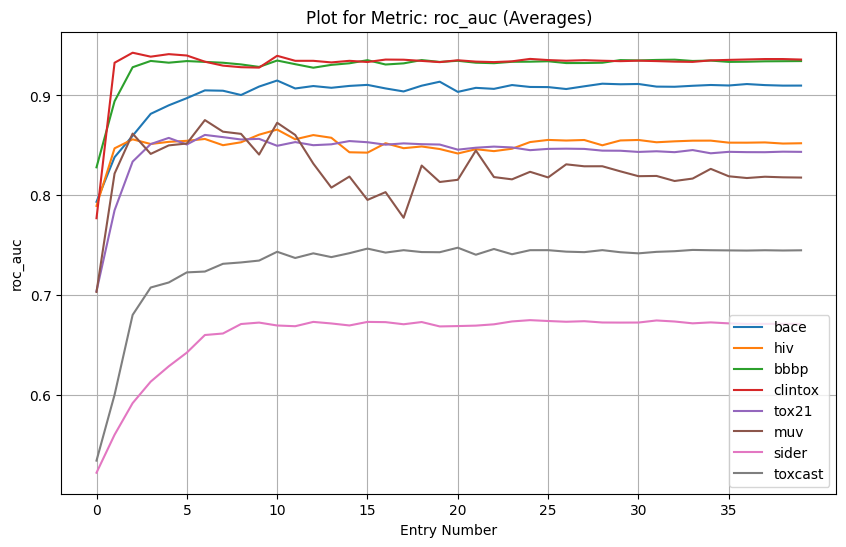

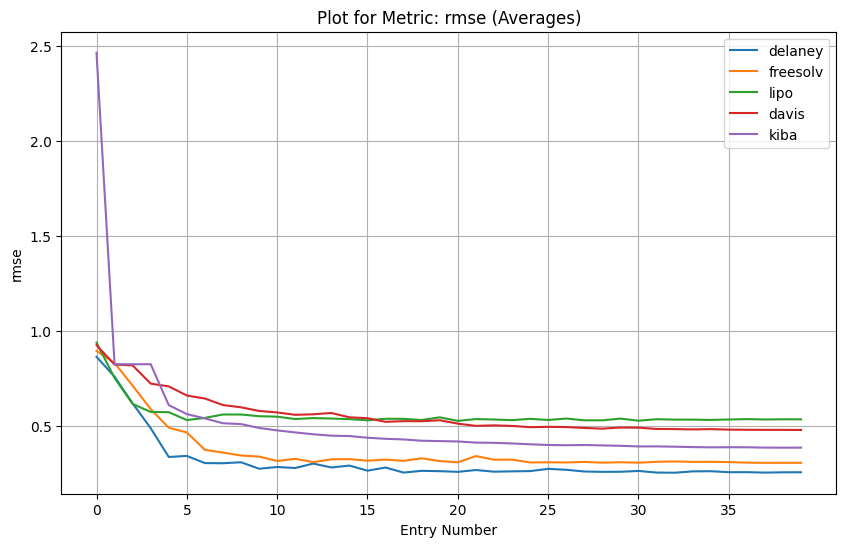

In [29]:

# Function to extract data by metric and compute averages
def extract_averages_by_metric(nested_dict):
    metrics = {}
    for task_name, records in nested_dict.items():
        for record in records:
            for metric, value in record.items():
                if metric not in metrics:
                    metrics[metric] = {}
                if task_name not in metrics[metric]:
                    metrics[metric][task_name] = []
                # Compute average if value is an array, or use the scalar value directly
                if isinstance(value, np.ndarray):
                    metrics[metric][task_name].append(value.mean())
                else:
                    metrics[metric][task_name].append(value)
    return metrics

# Extract data grouped by metric with averages
metrics_data = extract_averages_by_metric(eval_metrics)

# Plot data for each metric
for metric, tasks in metrics_data.items():
    plt.figure(figsize=(10, 6))
    for task_name, values in tasks.items():
        # Plot averages for this task
        plt.plot(range(len(values)), values, label=task_name)

    # Customize the plot
    plt.title(f"Plot for Metric: {metric} (Averages)")
    plt.xlabel("Entry Number")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks every 5 entries
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(ticks=range(0, max_entries, 5))

    # Show the plot
    plt.show()

In [30]:


# Compute the highest average or minimum values based on task type, including epoch
highest_scores = {}

for task_name, results in eval_metrics.items():
    if task_name in ["lipo", "delaney", "freesolv", "kiba","davis"]:  # These use 'mse'
        comparison_func = np.min
        metric_key = 'min_value'
    else:  # All other tasks use 'roc_auc'
        comparison_func = np.mean
        metric_key = 'highest_avg'
    
    best_metric = float('inf') if metric_key == 'min_value' else float('-inf')
    best_result = None
    best_epoch = None
    
    for entry_id, result in enumerate(results):
        for metric_type, values in result.items():
            values = np.array(values)  # Ensure values are NumPy arrays
            metric = comparison_func(values)  # Compute min or mean
            
            if (metric_key == 'min_value' and metric < best_metric) or \
               (metric_key == 'highest_avg' and metric > best_metric):
                best_metric = metric
                best_result = values
                best_epoch = entry_id // 11  # Calculate the epoch
    
    # Store the best metric, original values, and epoch
    highest_scores[task_name] = {
        metric_key: best_metric,
        'original_values': best_result.tolist(),  # Convert back to list for output
        'epoch': best_epoch
    }

# Output the results
for task_name, info in highest_scores.items():
    metric_key = 'min_value' if task_name in ["lipo", "delaney", "freesolv",'kiba','davis'] else 'highest_avg'
    print(f"{task_name}:")
    print(f"  {metric_key.capitalize().replace('_', ' ')}: {info[metric_key]}")
    print(f"  Original Values: {info['original_values']}")
    print(f"  Epoch: {info['epoch']}")


bace:
  Highest avg: 0.914997804128239
  Original Values: 0.914997804128239
  Epoch: 0
hiv:
  Highest avg: 0.865784842755888
  Original Values: 0.865784842755888
  Epoch: 0
bbbp:
  Highest avg: 0.9359141292735044
  Original Values: 0.9359141292735044
  Epoch: 2
clintox:
  Highest avg: 0.9428892800668318
  Original Values: [0.9509025270758122, 0.9348760330578513]
  Epoch: 0
tox21:
  Highest avg: 0.8604350232513163
  Original Values: [0.7849252053411645, 0.8459410925299427, 0.9136066978706572, 0.8857812027802962, 0.7606536981934722, 0.8467376115231646, 0.8583555689447409, 0.8478859096830221, 0.8877165397771158, 0.8687863461152827, 0.920478827787711, 0.9043515784692255]
  Epoch: 0
muv:
  Highest avg: 0.8752964064031029
  Original Values: [0.9084934277047523, 0.9424386521075496, 0.7504810413129599, 0.9105593607305935, 0.9303911622139556, 0.847001611418048, 0.8825852036575229, 0.9823446327683616, 0.890128117135667, 0.8123861566484517, 0.8133184011026878, 0.9133860475549574, 0.88684119875990

In [31]:

# Function to extract data by metric and compute averages
def extract_averages_by_metric(nested_dict):
    metrics = {}
    for task_name, records in nested_dict.items():
        for record in records:
            for metric, value in record.items():
                if metric not in metrics:
                    metrics[metric] = {}
                if task_name not in metrics[metric]:
                    metrics[metric][task_name] = []
                # Compute average if value is an array, or use the scalar value directly
                if isinstance(value, np.ndarray):
                    metrics[metric][task_name].append(value.mean())
                else:
                    metrics[metric][task_name].append(value)
    return metrics

# Extract data grouped by metric with averages
metrics_data = extract_averages_by_metric(eval_metrics)

# Find best scores for each metric and task
best_scores = {}
for task_name, records in eval_metrics.items():
    for record_id, record in enumerate(records):
        for metric, value in record.items():
            if task_name not in best_scores:
                best_scores[task_name] = {}
            if metric not in best_scores[task_name]:
                best_scores[task_name][metric] = {"best_value": None, "entry_id": None}
            if isinstance(value, np.ndarray):
                score = value.mean()
            else:
                score = value
            # Update the best score if this is the highest (or lowest for MSE)
            if (
                best_scores[task_name][metric]["best_value"] is None or
                (metric == "rmse" and score < best_scores[task_name][metric]["best_value"]) or
                (metric != "rmse" and score > best_scores[task_name][metric]["best_value"])
            ):
                best_scores[task_name][metric] = {"best_value": score, "entry_id": record_id}

# Define A4 size in inches
a4_size = ( 17.69,8.27)  # A4 in inches (width, height)

# List of colors to cycle through manually
color_list = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Plot data for each metric and mark the best scores
for metric, tasks in metrics_data.items():
    plt.figure(figsize=a4_size)  # Set figure size to A4

    for i, (task_name, values) in enumerate(tasks.items()):
        color = color_list[i % len(color_list)]  # Cycle through the predefined colors
        # Plot averages for this task
        plt.plot(range(len(values)), values, label=f"{task_name} (avg)", color=color)

        # Overlay the best score if available
        if task_name in best_scores and metric in best_scores[task_name]:
            best_entry = best_scores[task_name][metric]
            best_value = best_entry["best_value"]
            best_id = best_entry["entry_id"]
            best_epoch = best_id  # Corrected epoch position for plotting

            # Mark the best point on the plot
            plt.scatter(best_epoch, best_value, color=color, s=100, zorder=5, label=f"{task_name} (best)")
            plt.annotate(f"Best: {best_value:.3f}", 
                         (best_epoch, best_value), 
                         textcoords="offset points", 
                         xytext=(0, 10), ha="center", color=color)

    # Customize the plot
    plt.title(f"Plot for Metric: {metric} (Averages with Best Values)")
    plt.xlabel("Entry Number")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    # Set x-axis ticks every 11 entries
    max_entries = max(len(values) for values in tasks.values())
    plt.xticks(ticks=range(0, max_entries , 5))
    # Save the plot
    filename = f"{metric}_plot_with_best_values_{notebook_name}.pdf"
    save_path = os.path.join("result_graphs", filename)
    plt.savefig(save_path, format="pdf", dpi=300, bbox_inches="tight")
    print(f"Plot saved as {save_path}")
    plt.close()  # Close the figure to free memory


Plot saved as result_graphs\roc_auc_plot_with_best_values_Absolute_MLT-Copy17_solo.pdf
Plot saved as result_graphs\rmse_plot_with_best_values_Absolute_MLT-Copy17_solo.pdf


In [32]:
metrics_data

{'roc_auc': {'bace': [np.float64(0.7933025911286781),
   np.float64(0.8381203337725077),
   np.float64(0.8595740008783487),
   np.float64(0.881576635924462),
   np.float64(0.8901185770750988),
   np.float64(0.8973210364514713),
   np.float64(0.9051163812033377),
   np.float64(0.9047650417215634),
   np.float64(0.9004611330698288),
   np.float64(0.9089371980676328),
   np.float64(0.914997804128239),
   np.float64(0.9070267896354852),
   np.float64(0.9094642072902943),
   np.float64(0.9077075098814229),
   np.float64(0.9095959595959596),
   np.float64(0.9106280193236715),
   np.float64(0.907070707070707),
   np.float64(0.904040404040404),
   np.float64(0.9098155467720684),
   np.float64(0.9138120333772507),
   np.float64(0.9036012296881862),
   np.float64(0.9076635924462011),
   np.float64(0.9066315327184893),
   np.float64(0.9104523495827843),
   np.float64(0.9085419411506368),
   np.float64(0.9084101888449714),
   np.float64(0.906477821695213),
   np.float64(0.9092007026789635),
   np.

In [25]:

# Define save directory
save_dir = "my_trained_model_"+notebook_name
os.makedirs(save_dir, exist_ok=True)

# Save model weights and config
trainer.model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)  # If using a tokenizer

print(f"Model saved to {save_dir}")

Model saved to my_trained_model_Absolute_MLT-Copy17


In [26]:
torch.save({
    "step": 20,
    "optimizer": optimizer.state_dict()
}, os.path.join(save_dir, "optimizer_state.pt"))

#torch.save(optimizer_state, os.path.join(save_dir, "optimizer_state.pt"))

print("Optimizer state saved.")

Optimizer state saved.
